## Problem Statement

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. 

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

<img src="2560px-Ride_hailing_services_Wikivoyage_banner.jpg">

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

## 1. Exploratory Data Analysis
Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

### 1.1 Load Libraries

In [394]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
# from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)

In [395]:
# Some more imports
#importing KNN regressor and metric mse

from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as MAE


### Load Data

In [396]:
df = pd.read_csv('/Users/aryan/Downloads/EDA+ML-Final Project/nyc_taxi_trip_duration.csv')

### File structure and content

In [397]:
print('We have {} rows.'.format(df.shape[0]))
print('We have {} columns'.format(df.shape[1]))
df.iloc[1,:]

We have 729322 rows.
We have 11 columns


id                              id0889885
vendor_id                               1
pickup_datetime       2016-03-11 23:35:37
dropoff_datetime      2016-03-11 23:53:57
passenger_count                         2
pickup_longitude               -73.988312
pickup_latitude                 40.731743
dropoff_longitude              -73.994751
dropoff_latitude                40.694931
store_and_fwd_flag                      N
trip_duration                        1100
Name: 1, dtype: object

At first glance, we can see the types of each variable and what they look like. 

### Missing Values
Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

In [398]:
np.sum(pd.isnull(df))

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Fortunately, in this dataset we do not have any missing values which is great.

### Reformatting features & Checking consistency
There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features. 

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated pick up and drop off datetime. We will check whether the given duration is consistent with the calculated trip duration 

In [399]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]
duration_difference.shape

(0, 12)

This implies that there is no inconsistency in data wrt the drop location and trip duration

### Target Exploration
In this section we will take a look at the trip duration which is the target variable. It is crucial to understand it in detail as this is what we are trying to predict accurately.

In [400]:
df['trip_duration'].describe()/3600 # Trip duration in hours

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

Woah! There is a trip with duration of 979 hours. This is a huge outlier and might create problems at the prediction stage. One idea is to log transform the trip duration before prediction to visualise it better.

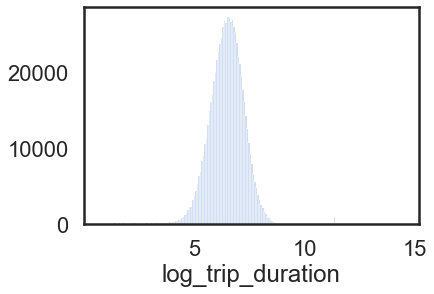

In [401]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
sns.distplot(df['log_trip_duration'], kde = False, bins = 200)
plt.show()

We find:

1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.

### Univariate Visualization
First of all, let us look at some of the binary features. Looking at each feature might uncover some insight that might be useful at later modelling stages

Text(0, 0.5, 'Frequency')

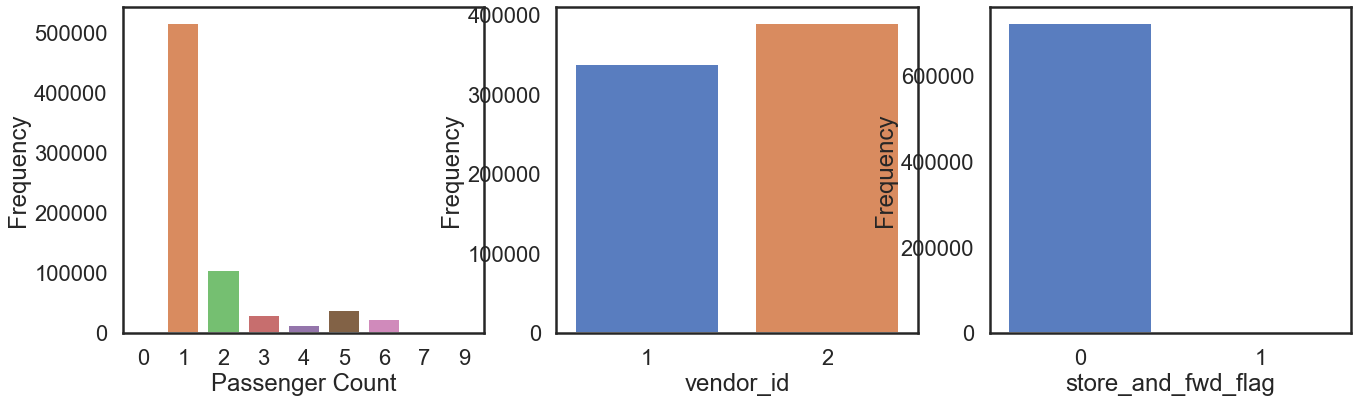

In [402]:
# Binary Features
plt.figure(figsize=(22, 6))
#fig, axs = plt.subplot(ncols=2)

# Passenger Count
plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')


# vendor_id
plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')


Observations:
1. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
2. Vendor 2 has more number of trips as compared to vendor 1
3. The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor (“0”) or held in the memory of the taxi because there was no connection to the server (“1”), show that there was almost no storing taking place

Now, we will delve into the datetime features to understand the trend of number of hourly/monthly/daily taxi trips 

In [403]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

Clearly, These trips are for first 6 months of 2016. To look at trends, we first need to extract week days and hour of day from the pickup date.

In [404]:
df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour

Text(0, 0.5, 'Total number of pickups')

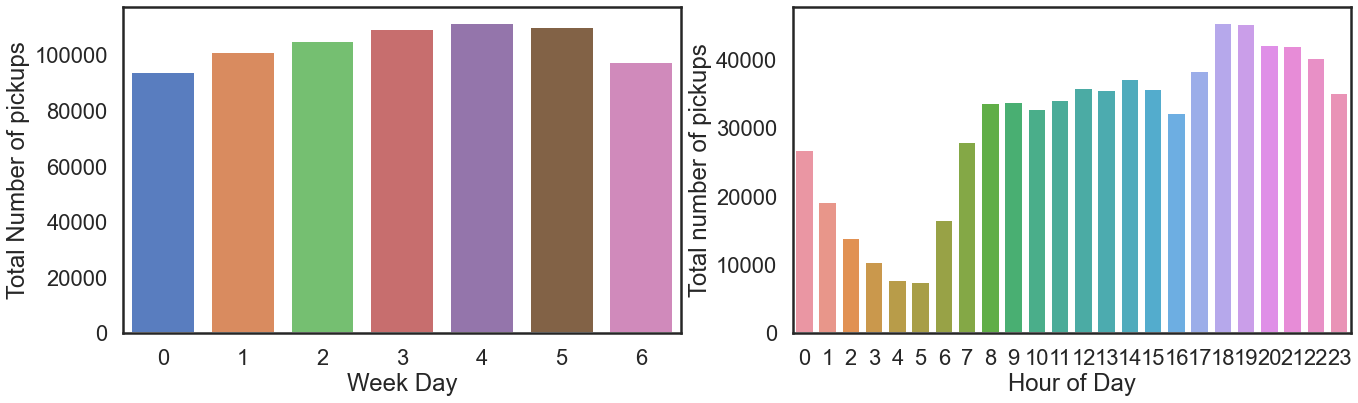

In [405]:

# Datetime features
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(121)
sns.countplot(df['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')

# vendor_id
plt.subplot(122)
sns.countplot(df['hour_of_day'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')


* Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
* Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.

### Lattitude & Longitude

Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.

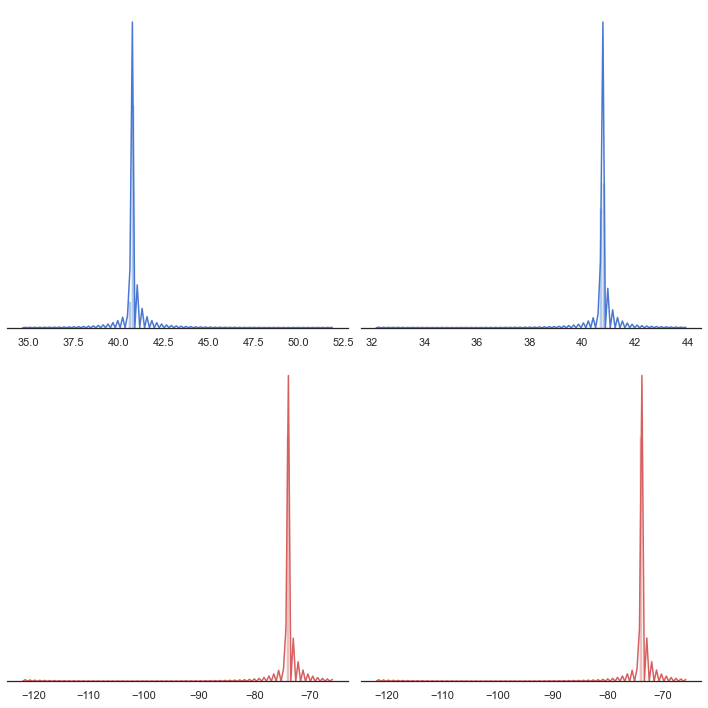

In [406]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

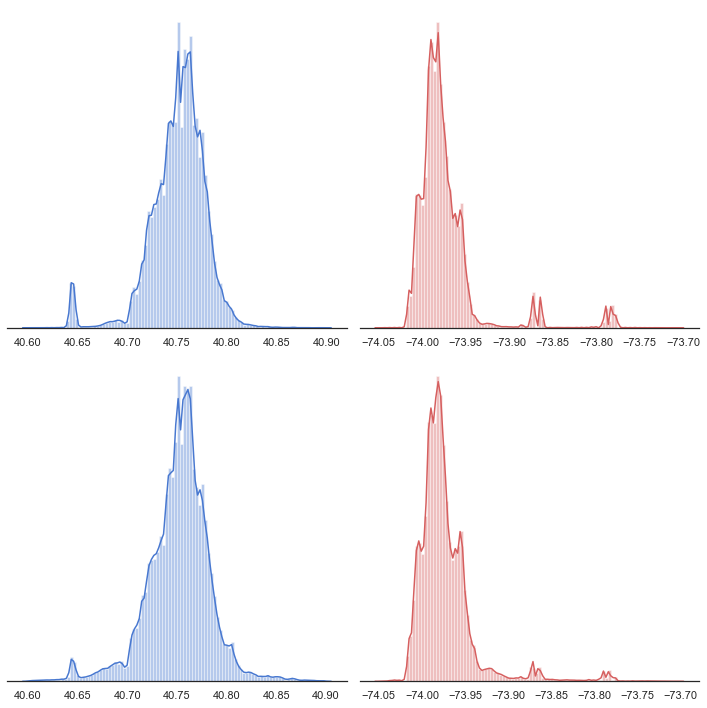

In [407]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lat long only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms


### Bivariate Relations with Target
Now that we have gone through all the basic features one by one. Let us start looking at their relation with the target. This will help us in selecting and extracting features at the modelling stage.

In [408]:
df.columns
data = df.copy()

### Trip Duration vs Weekday

For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

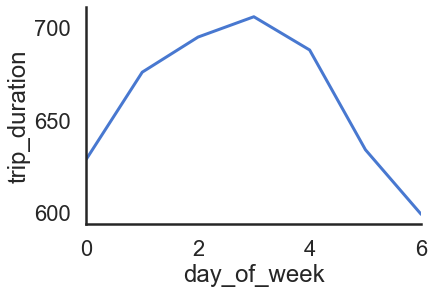

In [409]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", value="trip_duration")
sns.despine(bottom = False)

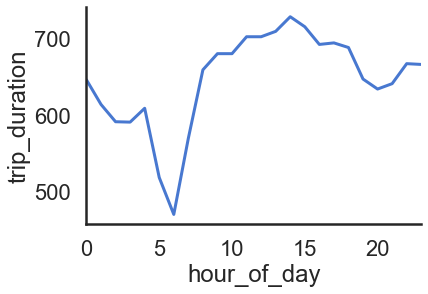

In [410]:

summary_hourly_avg_duration = pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
summary_hourly_avg_duration.reset_index(inplace = True)
summary_hourly_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_hourly_avg_duration, time="hour_of_day", unit = "unit", value="trip_duration")
sns.despine(bottom = False)



* Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
* It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration

### vendor_id vs Trip Duration

Let's check how the trip duration varies for different vendors.

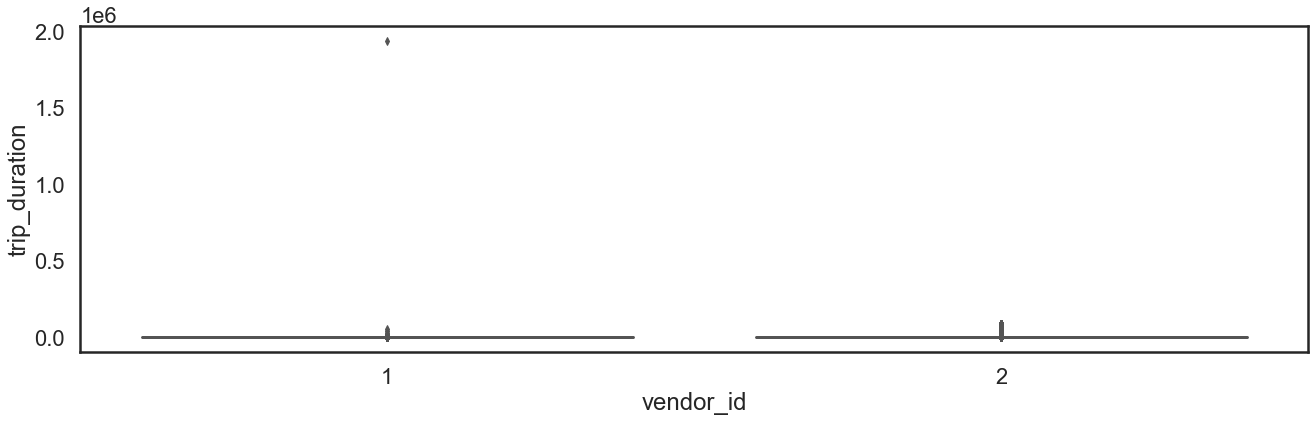

In [411]:
plt.figure(figsize=(22, 6))
sns.boxplot(x="vendor_id", y="trip_duration", data=df)
plt.show()


Woah! This did not came out as expected. The only thing I can see from this boxplot is that for vendor 2, there are a number of outliers exceeding 24 hours while vendor 1 does not have such long trips.

There could be 2 solutions to this:
1. Remove the huge outliers and plot again 
2. Look at median trip duration for both vendors on hourly basis

Let's try the first technique now and check trips below 50000 seconds only

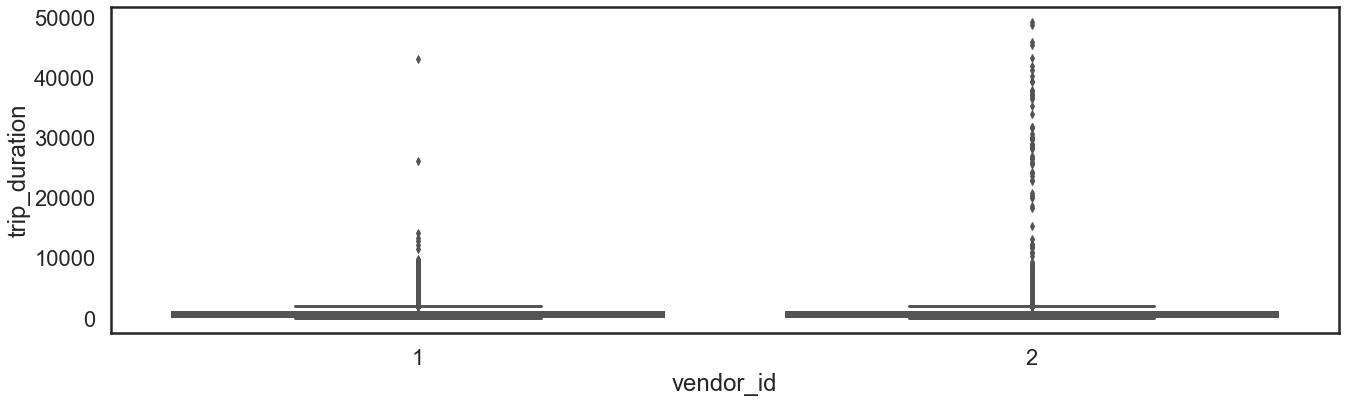

In [412]:
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 50000]
sns.boxplot(x="vendor_id", y="trip_duration", data=df_sub)
plt.show()

As you can see, we were in a false perception earlier that vendor 1 had more outliers. Since the median is just around 600 seconds, we observe that vendor 2 has many more outliers as compared to vendor 1. Next, to confirm this, we will quickly look at the mean wrt day of week for both vendors using tsplot (time series plot) from seaborn.

### Mean Trip Duration Vendor Wise

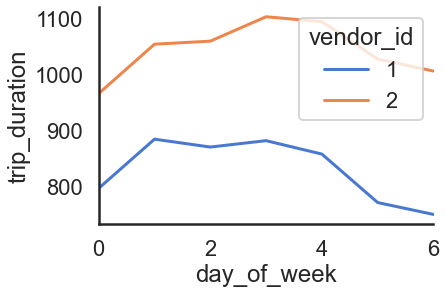

In [413]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)



### Median Trip Duration Vendor Wise

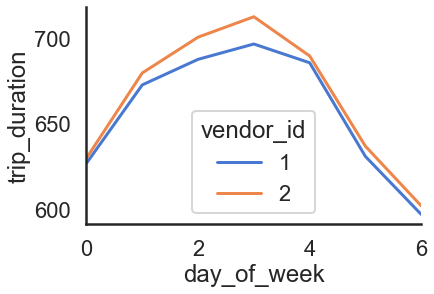

In [414]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)



Median trip duration does not vary much as can be seen from the above plot for different vendors. It emphasises the importance of looking at the correct measure for central tendency for analysis.

### Trip Duration vs Passenger Count

Again as we are aware, there are a large number of outliers for trip duration and we will not be able to observe the differences. For this, we have taken a cutoff of 10000 seconds and used a boxplot.

In [415]:
df.passenger_count.value_counts()

1    515243
2    104576
5     38776
3     29561
6     24035
4     13972
0        31
9         1
Name: passenger_count, dtype: int64

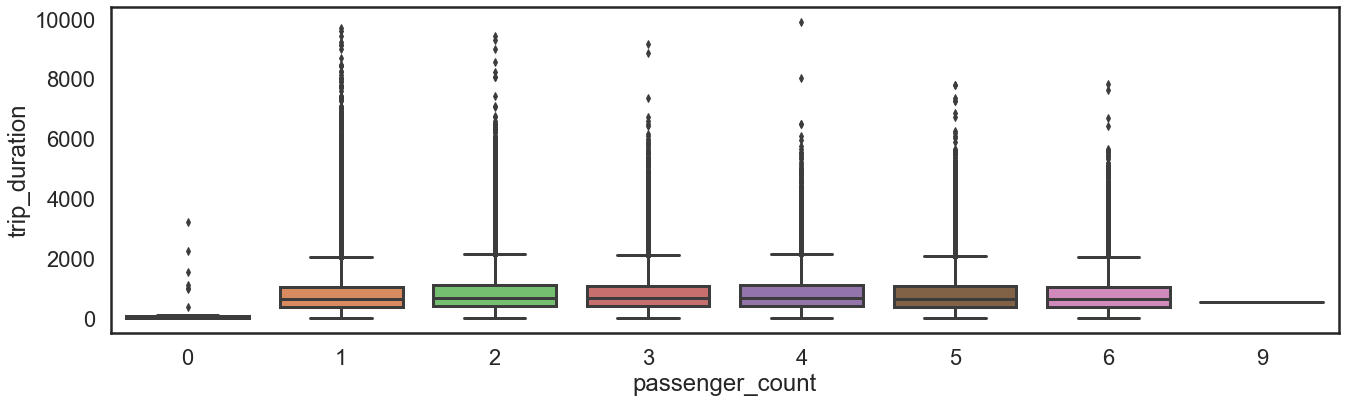

In [416]:
df.passenger_count.value_counts()
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()



* The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
* Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

### Visualise most frequently occuring Pickup points on the lattitude-longitude Map

Here, we try to visualise the most frequently occuring pickup points on the map and check how it is distributed spatially.

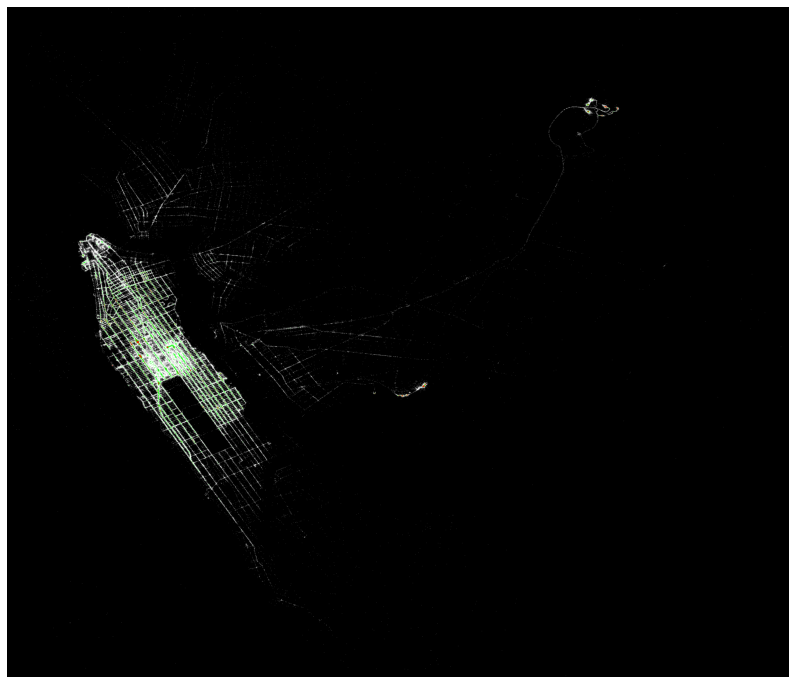

In [417]:

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df_data_new['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 255
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

Findings - From the heatmap kind of image above -

* White points - 1-10 trips have white as pickup point
* Green points - 10-25 trips have green as pickup point
* Red points - More than 25 trips have red as pickup point

As expected there are a few small clusters for hot pickup points as displayed by red in the above plot. Most pickup points have less than 10 trips and distributed all over the city.

If you go and have a look at an actual map of New York City, red and green points are mostly concentrated around the Manhatten Area

### Correlation Heatmap

Let us quickly look at the correlation heatmap to check the correlations amongst all features.

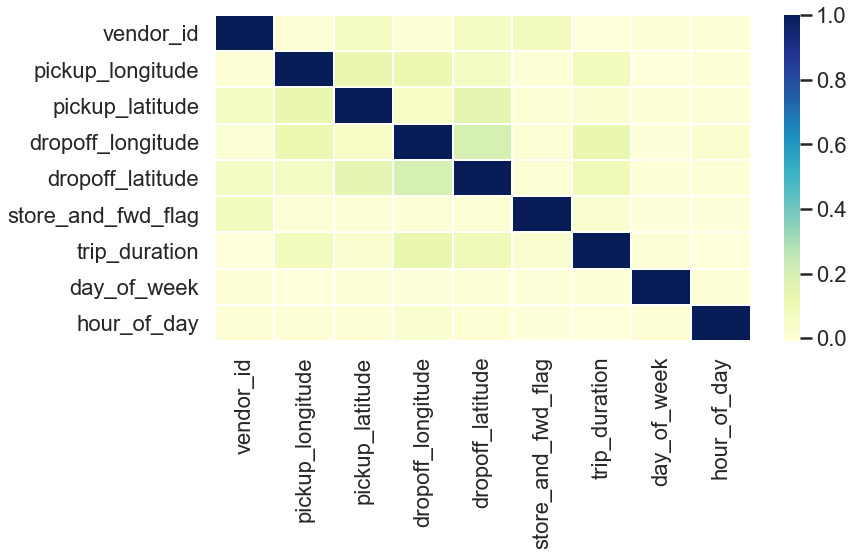

In [418]:
plt.figure(figsize=(12, 6))
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count','check_trip_duration','log_trip_duration'],
        axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

### Conclusions
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.
4. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
5. Vendor 2 has more number of trips as compared to vendor 1
6. Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
7. Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
8. We see that most trips are concentrated between these lat long only with a few significant clusters. These clusters are represented by the numerous peaks in the lattitude and longitude histograms
9. Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
10. It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration
11. Median trip duration does not vary much as can be seen from the above plot for different vendors.
12. The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
13. Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.
14. From the correlation heatmap we see that the lattitude and longitude features have higher correlation with the target as compared to the other features.

In [419]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration,log_trip_duration,day_of_week,hour_of_day
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,400,400.0,5.993961,0,16
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,1100.0,7.003974,4,23
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,1635.0,7.400010,6,17
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,1141.0,7.040536,1,9
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,848,848.0,6.744059,2,6


In [420]:
df.head()

,vendor_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,hour_of_day
0,2,-73.953918,40.778873,-73.963875,40.771164,0,400,0,16
1,1,-73.988312,40.731743,-73.994751,40.694931,0,1100,4,23
2,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,6,17
3,2,-73.961670,40.759720,-73.956779,40.780628,0,1141,1,9
4,1,-74.017120,40.708469,-73.988182,40.740631,0,848,2,6


In [421]:
#Check count of unique id's in the dataset
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(data.id.nunique()))

#Convert timestamp to datetime format to fetch the other details as listed below
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
data['weekday'] = data.pickup_datetime.dt.day_name()
data['month'] = data.pickup_datetime.dt.month_name()

data['pickup_hour'] = data.pickup_datetime.dt.hour

## Using Haversine formula to calculate the distances between the pickup and drop points.
# Calc_distance is a function to calculate the distance usign haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

#Calculate distance and assign new column to the dataframe.
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

#Calculate Speed in km/h for further insights
data['speed'] = (data.distance/(data.trip_duration/3600))

#Check the type of each variable
data.dtypes.reset_index()

newdata = pd.get_dummies(data.drop(['id','pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration','distance','speed'],axis =1))

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns, axis=1, inplace=False) #avoid dummy trap
newdata = pd.concat([newdata,dummy], axis = 1)

dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns, axis=1, inplace=False) #avoid dummy trap
newdata = pd.concat([newdata,dummy], axis = 1)


dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns, axis=1, inplace=False) #avoid dummy trap
newdata = pd.concat([newdata,dummy], axis = 1)


transition_data = data.pop('id')
newdata = pd.concat([newdata,transition_data], axis = 1)
transition_data = data.pop('pickup_datetime')
newdata = pd.concat([newdata,transition_data], axis = 1)
transition_data = data.pop('dropoff_datetime')
newdata = pd.concat([newdata,transition_data], axis = 1)
transition_data = data.pop('pickup_longitude')
newdata = pd.concat([newdata,transition_data], axis = 1)
transition_data = data.pop('pickup_latitude')
newdata = pd.concat([newdata,transition_data], axis = 1)
transition_data = data.pop('dropoff_longitude')
newdata = pd.concat([newdata,transition_data], axis = 1)
transition_data = data.pop('dropoff_latitude')
newdata = pd.concat([newdata,transition_data], axis = 1)
transition_data = data.pop('distance')
newdata = pd.concat([newdata,transition_data], axis = 1)
transition_data = data.pop('speed')
newdata = pd.concat([newdata,transition_data], axis = 1)
transition_data = data.pop('weekday')
newdata = pd.concat([newdata,transition_data], axis = 1)

transition_data = data.pop('trip_duration')
newdata = pd.concat([newdata,transition_data], axis = 1)

There are 726195 unique id's in Training dataset, which is equal to the number of records


In [422]:
newdata.head()

,vendor_id,passenger_count,store_and_fwd_flag,check_trip_duration,log_trip_duration,day_of_week,hour_of_day,pickup_hour,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,month_April,month_February,month_January,month_June,month_March,month_May,pickup_hour_0,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,vendor_id_1,vendor_id_2,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_9,id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,speed,weekday,trip_duration
0,2,1,0,400.0,5.993961,0,16,16,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,id1080784,2016-02-29 16:40:21,2016-02-29 16:47:01,-73.953918,40.778873,-73.963875,40.771164,1.199074,10.791668,Monday,400
1,1,2,0,1100.0,7.003974,4,23,23,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,id0889885,2016-03-11 23:35:37,2016-03-11 23:53:57,-73.988312,40.731743,-73.994751,40.694931,4.129117,13.513473,Friday,1100
2,2,2,0,1635.0,7.400010,6,17,17,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,id0857912,2016-02-21 17:59:33,2016-02-21 18:26:48,-73.997314,40.721458,-73.948029,40.774918,7.250763,15.964983,Sunday,1635
3,2,6,0,1141.0,7.040536,1,9,9,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,id3744273,2016-01-05 09:44:31,2016-01-05 10:03:32,-73.961670,40.759720,-73.956779,40.780628,2.361101,7.449573,Tuesday,1141
4,1,1,0,848.0,6.744059,2,6,6,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,id0232939,2016-02-17 06:42:23,2016-02-17 06:56:31,-74.017120,40.708469,-73.988182,40.740631,4.328540,18.375877,Wednesday,848


In [423]:
#seperating independent and dependent variables
x = newdata.drop(['trip_duration','vendor_id','passenger_count','check_trip_duration','log_trip_duration','day_of_week','hour_of_day','pickup_hour','id','pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','weekday'], axis=1)
y = newdata['trip_duration']
x.shape, y.shape

((726195, 50), (726195,))

In [424]:
x

,store_and_fwd_flag,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,month_April,month_February,month_January,month_June,month_March,month_May,pickup_hour_0,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,vendor_id_1,vendor_id_2,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_9,distance,speed
0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1.199074,10.791668
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,4.129117,13.513473
2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,7.250763,15.964983
3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2.361101,7.449573
4,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,4.328540,18.375877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1.120224,13.624352
729318,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.728706,8.328065
729319,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2.298779,12.296587
729320,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.846317,6.815975


In [425]:
# Importing Train test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 56)

# Implementing Benchmark Model


In [426]:
# Creating Benchmark Model

from sklearn.utils import shuffle
benchmarkdata = newdata.copy()# 
# Shuffling the Dataset
benchmarkdata = shuffle(benchmarkdata, random_state = 42)

#creating 4 divisions
div = int(benchmarkdata.shape[0]/4)

# 3 parts to train set and 1 part to test set
train = benchmarkdata.loc[:3*div+1,:]
test = benchmarkdata.loc[3*div+1:]

In [427]:
train.head()

,vendor_id,passenger_count,store_and_fwd_flag,check_trip_duration,log_trip_duration,day_of_week,hour_of_day,pickup_hour,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,month_April,month_February,month_January,month_June,month_March,month_May,pickup_hour_0,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,vendor_id_1,vendor_id_2,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_9,id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,speed,weekday,trip_duration
78016,2,2,0,2160.0,7.678326,4,23,23,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,id2332378,2016-01-22 23:28:55,2016-01-23 00:04:55,-73.985313,40.718601,-73.961151,40.661198,6.700211,11.167019,Friday,2160
38313,1,1,0,295.0,5.690359,3,9,9,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,id2687968,2016-06-02 09:23:26,2016-06-02 09:28:21,-73.982719,40.754265,-73.973457,40.752434,0.806306,9.839661,Thursday,295
206534,2,1,0,237.0,5.472271,5,15,15,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,id3998611,2016-06-11 15:26:21,2016-06-11 15:30:18,-73.978203,40.752541,-73.983177,40.756199,0.583982,8.870613,Saturday,237
564809,2,1,0,717.0,6.576470,1,16,16,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,id2674901,2016-02-16 16:39:18,2016-02-16 16:51:15,-73.975250,40.787827,-73.950958,40.814068,3.563015,17.889614,Tuesday,717
100394,2,3,0,1076.0,6.981935,0,22,22,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,id0158105,2016-02-01 22:29:48,2016-02-01 22:47:44,-73.862511,40.768929,-73.959373,40.766781,8.160783,27.303734,Monday,1076


In [428]:
test.head()

,vendor_id,passenger_count,store_and_fwd_flag,check_trip_duration,log_trip_duration,day_of_week,hour_of_day,pickup_hour,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,month_April,month_February,month_January,month_June,month_March,month_May,pickup_hour_0,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,vendor_id_1,vendor_id_2,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_9,id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,speed,weekday,trip_duration
544645,2,1,0,441.0,6.091310,5,12,12,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,id2991926,2016-01-09 12:10:59,2016-01-09 12:18:20,-73.979713,40.739605,-73.991188,40.723503,2.034825,16.610816,Saturday,441
307528,1,1,0,1088.0,6.993015,1,20,20,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,id3088194,2016-04-26 20:23:42,2016-04-26 20:41:50,-73.983772,40.738213,-74.010696,40.723618,2.789384,9.229581,Tuesday,1088
159533,1,1,0,1054.0,6.961296,1,11,11,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,id3555057,2016-04-05 11:30:18,2016-04-05 11:47:52,-73.990318,40.775635,-73.956398,40.766296,3.039341,10.381052,Tuesday,1054
246485,2,1,0,1831.0,7.513164,6,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,id0318634,2016-05-01 01:55:33,2016-05-01 02:26:04,-73.981110,40.760071,-73.863724,40.728016,10.511916,20.667885,Sunday,1831
342223,1,1,0,289.0,5.669881,5,9,9,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,id3481180,2016-05-07 09:51:41,2016-05-07 09:56:30,-73.975349,40.752922,-73.966606,40.760925,1.155117,14.389005,Saturday,289


In [429]:
# storing simple mean in a new column in the test set as "simple_mean"
test['simple_mean'] = train['trip_duration'].mean()

In [430]:
#calculating mean absolute error


simple_mean_error = MAE(test['trip_duration'] , test['simple_mean'])
simple_mean_error

620.3379389183658

In [431]:
#Mean trip duration with respect to weekday

out_type = pd.pivot_table(train, values='trip_duration', index = ['weekday'], aggfunc=np.mean)
out_type

,trip_duration
weekday,
Friday,979.852983
Monday,889.974706
Saturday,911.882585
Sunday,884.245917
Thursday,994.403635
Tuesday,957.871613
Wednesday,972.782865


In [432]:
# initializing new column to zero
test['trip_duration_mean'] = 0

# For every unique entry in Outlet_Identifier
for i in train['weekday'].unique():
  # Assign the mean value corresponding to unique entry
  test['trip_duration_mean'][test['weekday'] == str(i)] = train['trip_duration'][train['weekday'] == str(i)].mean()
   
 #calculating mean absolute error
out_type_error = MAE(test['trip_duration'] , test['trip_duration_mean'] )
out_type_error

619.0055843100433

In [433]:
#Mean trip duration with respect to pickup hour
pickup_hour_avg = pd.pivot_table(train, values='trip_duration', index = ['pickup_hour'], aggfunc=np.mean)
pickup_hour_avg

,trip_duration
pickup_hour,
0,896.689487
1,929.957091
2,906.781030
3,907.663522
4,902.488896
5,858.715120
6,700.877888
7,800.499929
8,931.304472


In [434]:
# initializing new column to zero
test['pickup_hour_mean'] = 0

# For every unique entry in Outlet_Identifier
for i in train['pickup_hour'].unique():
  # Assign the mean value corresponding to unique entry
  test['pickup_hour_mean'][test['pickup_hour'] == i] = train['trip_duration'][train['pickup_hour'] == i].mean()
    
#calculating mean absolute error
pickup_hour_error = MAE(test['trip_duration'] , test['pickup_hour'] )
pickup_hour_error    

943.155107663639

In [435]:
#Mean trip duration with respect to vendor id
vendor_id = pd.pivot_table(train, values = 'trip_duration', index = ['vendor_id'], aggfunc = np.mean)
vendor_id

,trip_duration
vendor_id,
1,826.698685
2,1044.433545


In [436]:
# Initializing empty column
test['vendor_id_mean'] = 0

# For every unique entry in Item_Identifier
for i in train['vendor_id'].unique():
  # calculate and assign mean corresponding to the uniques entries
  test['vendor_id_mean'][test['vendor_id'] == str(i)] = train['trip_duration'][train['vendor_id'] == str(i)].mean()
    
#calculating mean absolute error
out_loc_error = MAE(test['trip_duration'] , test['vendor_id_mean'] )
out_loc_error    

956.7447168506313

In [437]:
#Mean trip duration with respect to vendorid, weekday and pickup hour.
combo = pd.pivot_table(train, values = 'trip_duration', index = ['weekday','pickup_hour','vendor_id'], aggfunc = np.mean)
combo

trip_duration
weekday   pickup_hour vendor_id               
Friday    0           1             779.378486
                      2            1087.341235
          1           1             736.667674
                      2            1099.405042
          2           1             693.017150
...                                        ...
Wednesday 21          2             965.808949
          22          1             820.987828
                      2            1107.622783
          23          1             790.946828
                      2            1002.394882

[336 rows x 1 columns]

In [438]:
# Initiating new empty column
test['Super_mean'] = 0

# Assigning variables to strings ( to shorten code length)
s3 = 'weekday'
s2 = 'pickup_hour'
s1 = 'vendor_id'
# For every Unique Value in s1
for i in test[s1].unique():
  # For every Unique Value in s2
  for j in test[s2].unique():
        for k in test[s3].unique():
            # Calculate and Assign mean to new column, corresponding to both unique values of s1 and s2 simultaneously
            test['Super_mean'][(test[s1] == i) & (test[s2]==str(j)) & (test[s3]==str(k))] = train['trip_duration'][(train[s1] == i) & (train[s2]==str(j)) & (test[s3]==str(k))].mean()
            
#calculating mean absolute error
super_mean_error = MAE(test['trip_duration'] , test['Super_mean'] )
super_mean_error

#previous output = 956.744

956.7447168506313

# Implementing Decision Tree Regressor

In [439]:
# Fit
# Import model
from sklearn.tree import DecisionTreeRegressor

# Instantiate model object
dtree = DecisionTreeRegressor()

# Fit to training data
dtree.fit(x_train,y_train)
print(dtree)

test_predict = dtree.predict(x_test)
k = mse(y_test, test_predict)
print('Test MSE    ', k )


# PREVIOUS OUTPUT
#DecisionTreeRegressor()
#Test MSE     154315.2087148113

DecisionTreeRegressor()
Test MSE     190742.5935125947


In [477]:
from sklearn import metrics
print('\Decision Tree Performance Metrics')
dtr2 = metrics.explained_variance_score(y_test, test_predict)
dtmae = metrics.mean_absolute_error(y_test, test_predict)
dtmse = metrics.mean_squared_error(y_test, test_predict)
dtrmse = np.sqrt(metrics.mean_squared_error(y_test, test_predict))

print('R^2='+str(dtr2))
print('MAE:'+str(dtmae))
print('MSE:'+str(dtmse))
print('RMSE:'+str(dtrmse))

\Decision Tree Performance Metrics
R^2=0.9856091807787798
MAE:8.38424459110125
MSE:140914.6610836112
RMSE:375.38601610024205



# Implementing Random Forest Regressor

In [374]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 18)

# fit the regressor with x and y data
regressor.fit(x_train, y_train)
print(regressor)

RandomForestRegressor(random_state=18)


In [450]:
test_predict = regressor.predict(x_test)
k = mse(y_test, test_predict)
print('Test MSE    ', k )

# PREVIOUS OUTPUT
# Test MSE     140511.36610669948

Test MSE     140914.6610836112


In [476]:
from sklearn import metrics
print('\nRandom Forest Performance Metrics')
rfr2 = metrics.explained_variance_score(y_test, test_predict)
rfmae = metrics.mean_absolute_error(y_test, test_predict)
rfmse = metrics.mean_squared_error(y_test, test_predict)
rfrmse = np.sqrt(metrics.mean_squared_error(y_test, test_predict))

print('R^2='+str(rfr2))
print('MAE:'+str(rfmae))
print('MSE:'+str(rfmse))
print('RMSE:'+ str(rfrmse))



Random Forest Performance Metrics
R^2=0.9856091807787798
MAE:8.38424459110125
MSE:140914.6610836112
RMSE:375.38601610024205


# Implementing Multivariate Linear Regression

In [376]:
newdata.head()
x1 = newdata['distance']
transition_data = newdata['speed']
x1 = pd.concat([x1,transition_data], axis = 1)
y1 = newdata['trip_duration']

# Importing Train test split
from sklearn.model_selection import train_test_split
x_train1,x_test1,y_train1,y_test1 = train_test_split(x1,y1, random_state = 56)

In [377]:
from sklearn.linear_model import LinearRegression

#  Instantiate model object
lreg = LinearRegression()

# Fit to training data
lreg.fit(x_train1,y_train1)
print(lreg)

# Predict
y_pred_lreg = lreg.predict(x_test1)

# Score It
k = mse(y_pred_lreg, y_test1)
print('Test MSE    ', k )


LinearRegression()
Test MSE     9358325.72108727


In [452]:
from sklearn import metrics
print('\nLinear Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_test1,y_pred_lreg))
print('MAE:',metrics.mean_absolute_error(y_test1,y_pred_lreg))
print('MSE:',metrics.mean_squared_error(y_test1,y_pred_lreg))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test1,y_pred_lreg)))


Linear Regression Performance Metrics
R^2= 0.04532907088239713
MAE: 375.20450055408594
MSE: 9348123.131933602
RMSE: 3057.4700541352163


In [378]:
lreg.coef_

array([216.5925353 , -67.39492105])

In [379]:
pd.DataFrame(lreg.coef_, 
             x_train1.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
distance,216.592535
speed,-67.394921


# Implementing Multivariate Linear Regression on another set of data

In [380]:
from sklearn.linear_model import LinearRegression

#  Instantiate model object
lreg = LinearRegression()

# Fit to training data
lreg.fit(x_train,y_train)
print(lreg)

# Predict
y_pred_lreg = lreg.predict(x_test)

# Score It
k = mse(y_pred_lreg, y_test)
print('Test MSE    ', k )
lreg.coef_

LinearRegression()
Test MSE     9348123.131933602


array([-2.71057582e+01,  2.71472800e+11,  2.71472800e+11,  2.71472800e+11,
        2.71472800e+11,  2.71472800e+11,  2.71472800e+11,  2.71472800e+11,
        6.21362545e+11,  6.21362545e+11,  6.21362545e+11,  6.21362545e+11,
        6.21362545e+11,  6.21362545e+11,  1.17101242e+12,  1.17101242e+12,
        1.17101242e+12,  1.17101242e+12,  1.17101242e+12,  1.17101242e+12,
        1.17101242e+12,  1.17101242e+12,  1.17101242e+12,  1.17101242e+12,
        1.17101242e+12,  1.17101242e+12,  1.17101242e+12,  1.17101242e+12,
        1.17101242e+12,  1.17101242e+12,  1.17101242e+12,  1.17101242e+12,
        1.17101242e+12,  1.17101242e+12,  1.17101242e+12,  1.17101242e+12,
        1.17101242e+12,  1.17101242e+12,  3.99678339e+12,  3.99678339e+12,
        6.72428983e+12,  6.72428983e+12,  6.72428983e+12,  6.72428983e+12,
        6.72428983e+12,  6.72428983e+12,  6.72428983e+12,  6.72428983e+12,
        2.17104419e+02, -6.93464195e+01])

In [381]:
pd.DataFrame(lreg.coef_, 
             x_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
passenger_count_5,6.724290e+12
passenger_count_3,6.724290e+12
passenger_count_6,6.724290e+12
passenger_count_1,6.724290e+12
passenger_count_2,6.724290e+12
passenger_count_4,6.724290e+12
passenger_count_9,6.724290e+12
passenger_count_0,6.724290e+12
vendor_id_2,3.996783e+12
vendor_id_1,3.996783e+12


In [474]:
from sklearn import metrics



print('\nLinear Regression Performance Metrics')
lrr2 = metrics.explained_variance_score(y_test,y_pred_lreg)
lrmae = metrics.mean_absolute_error(y_test,y_pred_lreg)
lrmse = metrics.mean_squared_error(y_test,y_pred_lreg)
lrrmse =np.sqrt(metrics.mean_squared_error(y_test,y_pred_lreg))

print('R^2=' + str(lrr2))
print('MAE:'+str(lrmae))
print('MSE:'+ str(lrmse))
print('RMSE:'+ str(lrrmse))


Linear Regression Performance Metrics
R^2=0.04532907088239713
MAE:375.20450055408594
MSE:9348123.131933602
RMSE:3057.4700541352163


# Implementing KNN Regression

In [382]:
# implementing KNN
# Importing the MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x = pd.DataFrame(x_scaled, columns = x.columns)
x.head()

# Creating instance of KNN
reg = KNN(n_neighbors = 5)

# Fitting the model
reg.fit(train_x, train_y)

# Predicting over the Train Set and calculating MSE
test_predict = reg.predict(x_test)
k = mse(test_predict, test_y)
print('Test MSE    ', k )
k

# Not running this part because it takes hours to complete on my machine. Just a reason why it's called lazy learning algo.

Test MSE     12253304.354043264


12253304.354043264

In [383]:
def Elbow(K):
  #initiating empty list
    test_mse = []
  
  #training model for evey value of K
    for i in K:
        #Instance of KNN
        reg = KNN(n_neighbors = i)
        reg.fit(train_x, train_y)
        #Appending mse value to empty list claculated using the predictions
        tmp = reg.predict(test_x)
        tmp = mse(tmp,test_y)
        test_mse.append(tmp)
    
    return test_mse

Text(0.5, 1.0, 'Elbow Curve for test')

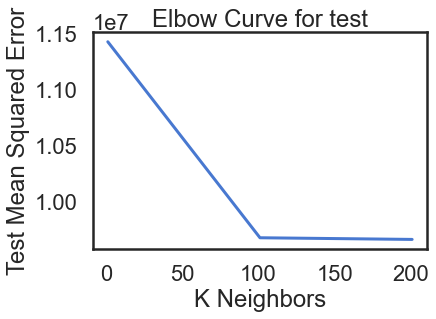

In [386]:
#Defining K range
k = range(1,300,100)
test = Elbow(k)
# plotting the Curves
plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('Test Mean Squared Error')
plt.title('Elbow Curve for test')

In [388]:
# Creating instance of KNN
reg = KNN(n_neighbors = 100)

# Fitting the model
reg.fit(train_x, train_y)

# Predicting over the Train Set and calculating MSE
test_predict = reg.predict(x_test)
k = mse(test_predict, test_y)
print('Test MSE    ', k )
k

# Not running this part because it takes hours to complete on my machine. Just a reason why it's called lazy learning algo.

Test MSE     10244777.341006039


10244777.341006039

In [472]:
from sklearn import metrics


knnr2 = metrics.explained_variance_score(test_predict, test_y)
knnmae = metrics.mean_absolute_error( test_predict, test_y)
knnmse = metrics.mean_squared_error( test_predict, test_y)
knnrmse =np.sqrt(metrics.mean_squared_error(test_predict, test_y))


print('\nLinear Regression Performance Metrics')
print('R^2='+str(knnr2))
print('MAE:'+str(knnmae))
print('MSE:'+str(knnmse))
print('RMSE:'+str(knnrmse))


Linear Regression Performance Metrics
R^2=0.9854869642016921
MAE:8.38424459110125
MSE:140914.6610836112
RMSE:375.38601610024205


# Plot of Train and Test Score

In [511]:
r2 = [dtr2,rfr2,lrr2,knnr2]
mae = [dtmae,rfmae,lrmae,knnmae]
mse = [dtmse,rfmse,lrmse,knnmse]
rmse = [dtrmse,rfrmse,lrrmse,knnrmse]
models = ['Decision Tree','Random Forest','Linear Regression','KNN']

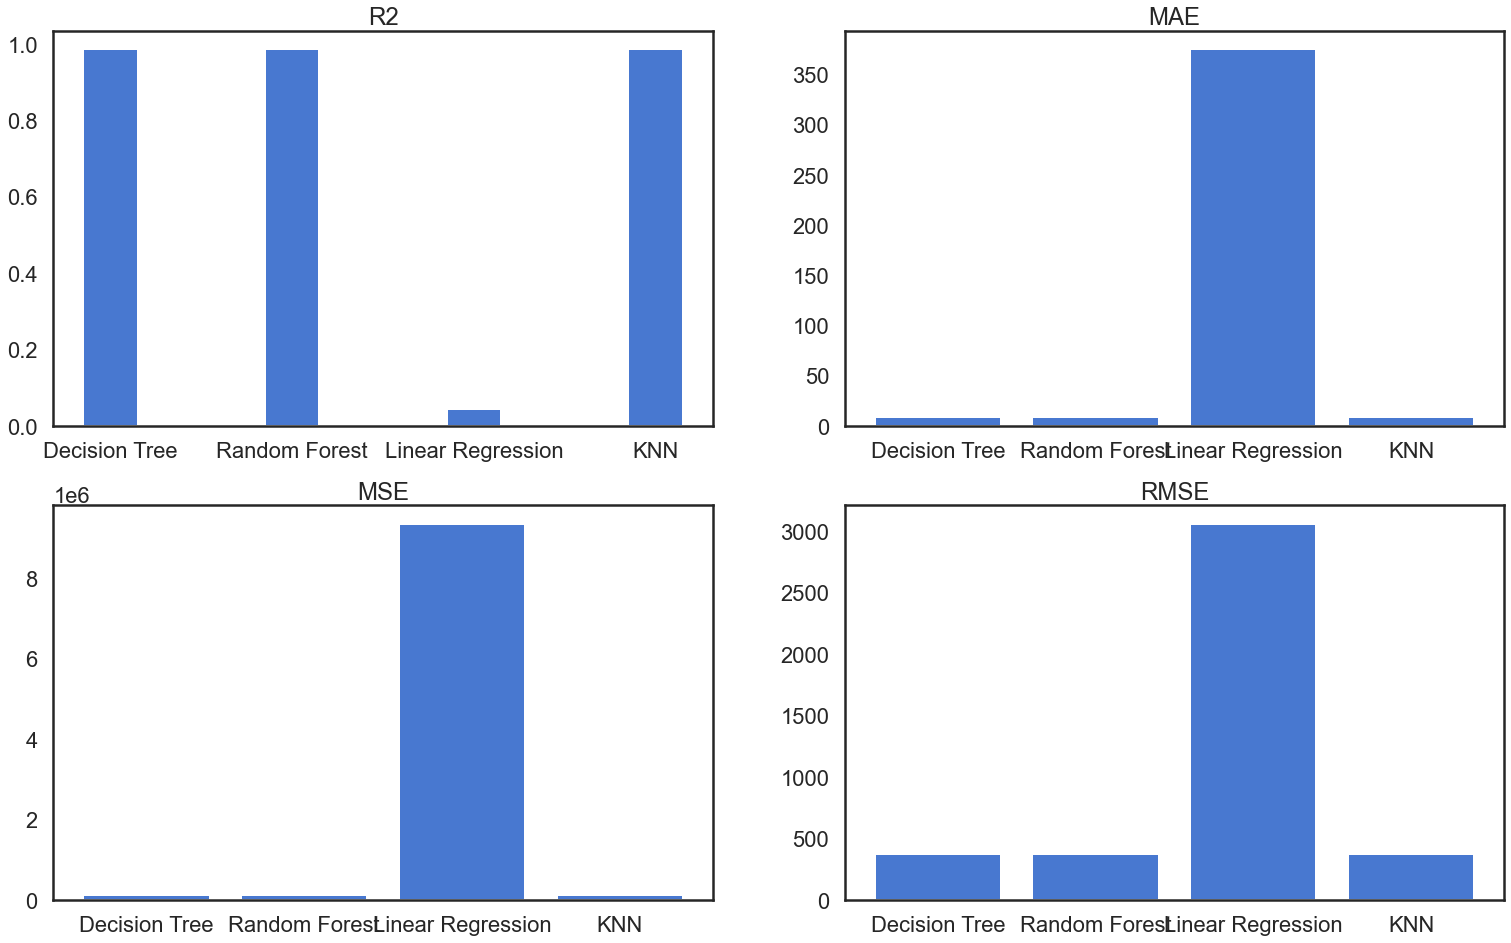

In [512]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2,figsize=(26,16))
  
# For Sine Function
axis[0, 0].bar(models, r2, width=0.3)
axis[0, 0].set_title("R2")
  
# For Cosine Function
axis[0, 1].bar(models,mae)
axis[0, 1].set_title("MAE")
  
# For Tangent Function
axis[1, 0].bar(models,mse)
axis[1, 0].set_title("MSE")
  
# For Tanh Function
axis[1, 1].bar(models,rmse)
axis[1, 1].set_title("RMSE")
  
# Combine all the operations and display
plt.show()